In [1]:
# Load in the packages
import numpy as np
import folktables
from folktables import ACSDataSource, ACSIncome

import os
import sys
import copy
sys.path.append('..')
import random
import FairCertModule
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import models, transforms
from FullyConnected import FullyConnected
import pytorch_lightning as pl

# Set random seeds
SEED = 0
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

dataset = "German"
if(dataset == "Coverage"):
    TEST_EPSILON = 0.15
else:
    TEST_EPSILON = 0.05   


In [2]:
# Data loaders

import folk_utils
if(dataset in ["Employ", "Folk", "Insurance", "Coverage"]):
    X_train, X_test, X_val, y_train, y_test, y_val, lp_epsilon, sr_epsilon = folk_utils.get_dataset(dataset)
    f_epsilon = lp_epsilon
elif(dataset in ["Adult", "Credit", "German"]):
    X_train, X_test, X_val, y_train, y_test, y_val, lp_epsilon, sr_epsilon = folk_utils.get_UCI_dataset(dataset)
    X_train = torch.Tensor(X_train); y_train = torch.Tensor(y_train)
    X_test = torch.Tensor(X_test); y_test = torch.Tensor(y_test)
    f_epsilon = torch.Tensor(lp_epsilon)

Raw cols: 
(800, 21)
['Unnamed: 0', 'account_status', 'duration', 'credit_history', 'purpose', 'credit_amount', 'savings_account', 'employment', 'installment_rate_pct', 'status_sex', 'debtors_guarantors', 'residence_since', 'property', 'age', 'other_installment_plans', 'housing', 'credits_num', 'job', 'dependants_num', 'telephone', 'foreign']
Raw cols: 
(200, 21)
['Unnamed: 0', 'account_status', 'duration', 'credit_history', 'purpose', 'credit_amount', 'savings_account', 'employment', 'installment_rate_pct', 'status_sex', 'debtors_guarantors', 'residence_since', 'property', 'age', 'other_installment_plans', 'housing', 'credits_num', 'job', 'dependants_num', 'telephone', 'foreign']
DATA SHAPES: 
(800, 59)
(200, 59)
(200, 59)
****


/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


In [3]:
# Load in the trained models

MODEL_STATE  = 'CA'
MODEL_YEAR   = '2015'
MODEL_WIDTH  = '256'
MODEL_METRIC = 'LP'

sgd_id = "SGD" 
pgd_id = "FAIR-PGD" 
ibp_id = "FAIR-IBP" 
glob_id = "FAIR-DRO"
ibpg_id = "FAIR-IBPG"

def load_model_from_id(model_id, dataset, width=MODEL_WIDTH):
    width = 512
    depth = 1
    if(model_id == "Toy"):
        model = FullyConnected(hidden_lay=1, hidden_dim=16, dataset=dataset)
    else:
        model = FullyConnected(hidden_lay=depth, hidden_dim=width, dataset=dataset)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    checkpoint = torch.load("%sModels/%s1_512.ckpt"%(dataset, model_id))
    model.load_state_dict(torch.load('%sModels/%s1_512.pt'%(dataset, model_id)))
    return model

#sgd_model = load_model_from_id(sgd_id, dataset)
#pgd_model = load_model_from_id(pgd_id, dataset)
#ibp_model = load_model_from_id(ibp_id, dataset)
glob_model = load_model_from_id(glob_id, dataset)
#ibpg_model = load_model_from_id(ibpg_id, dataset)

test_model = glob_model

In [4]:
from folk_utils import compute_DIF_certification

delta = 0.2
gamma = 0.05
N = 200
D = 20

val, trend, vg = compute_DIF_certification(test_model, f_epsilon, gamma, delta, 
                                       X_test, y_test, rand = True, N=N, iters=3000, rettrend=True, lr = 10000)



/Users/matthewwicker/Desktop/Development/CertificationOfDistributionalIF/Folktables/folk_utils.py:396: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1659484744261/work/torch/csrc/utils/tensor_new.cpp:204.)
  v = torch.Tensor([f_epsilon.numpy() for i in range(N)]).float()
100%|██████████████████████████████████████| 3000/3000 [00:11<00:00, 267.52it/s]


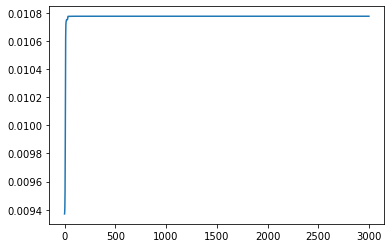

In [5]:
import matplotlib 
import matplotlib.pyplot as plt

plt.plot(trend)


In [6]:
from folk_utils import I
from tqdm import trange
N=200
def compute_DIF_falsification_s(model, f_epsilon, gamma, delta, X_test, y_test, lr=1.0, N=1000, iters=500, rettrend=False):
    convergence_trend = []
    try:
        v = torch.Tensor([f_epsilon.numpy() for i in range(N)]).float()
    except:
        v = torch.Tensor([f_epsilon for i in range(N)]).float()
    X = X_test[0:N].float()
    y = y_test[0:N].long()
    phi = torch.rand(X.shape) * gamma
    X_orig = copy.deepcopy(X)
    output = copy.deepcopy(model(X).detach())
    for i in trange(iters):
        phi.requires_grad_()
        with torch.enable_grad():
            new_out = model(X + phi)#I(model, X, y, v, vg, 2) 
            loss = torch.nn.functional.cross_entropy(new_out, output)
        loss.mean().backward()
        g = phi.grad
        phi = phi.detach()
        phi = phi + (lr * g) 
        n = torch.mean(torch.norm(phi))
        #print(n)
        if(n >  gamma):
            phi /= n
            phi *= gamma
        #vg = torch.clip(vg, 0, 1e3)
        n = torch.mean(torch.norm(phi))
        #print(n)
        eps = I(model, X + phi, y, v, delta, 2) 
        convergence_trend.append(float(eps.mean().detach()))
    if(rettrend):
        return eps.mean(), phi, convergence_trend
    else:
        return eps.mean(), phi
    
    
eps, phi, convergence_trend = compute_DIF_falsification_s(test_model, f_epsilon, 1.0, delta, 
                             X_test, y_test, N=N, iters=300, 
                             rettrend=True, lr = 10)




100%|████████████████████████████████████████| 300/300 [00:00<00:00, 402.03it/s]


In [7]:
print(eps)
print(torch.mean(torch.norm(phi)))
#I(test_model, X_test[0:100], y[0:100], f_epsilon, 0.1, 2) 

tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.9999)


In [8]:
from folk_utils import compute_DIF_falsification
delta = 0.02
gamma = 0.1
eps, convergence_trend = compute_DIF_falsification(test_model, f_epsilon, gamma, delta, 
                             X_test, y_test, N=N, iters=300, 
                             rettrend=True, rand=True, lr=20000)

100%|████████████████████████████████████████| 300/300 [00:00<00:00, 300.18it/s]


tensor(1.3479e-05, grad_fn=<MeanBackward0>)


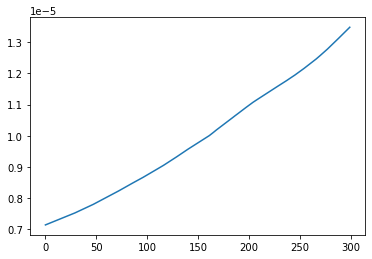

In [9]:
print(eps)
plt.plot(convergence_trend)

In [10]:
delta = 0.2
gamma = 0.05
N = 200
total_gaps = []
total_vals = []
for gamma in [0.01, 0.05, 0.1, 0.15, 0.2]:
#for gamma in [0.01, 0.02, 0.03, 0.04, 0.05]:
    gaps = []
    vals = []
    for i in range(3):
        lower_bound, convergence_trend = compute_DIF_falsification(test_model, f_epsilon, gamma, delta, 
                                 X_test, y_test, N=N, iters=250, rettrend=True, rand=True, lr=2.0)
        upper_bound, trend, vg = compute_DIF_certification(test_model, f_epsilon, gamma, delta,
                                           X_test, y_test, N=N, iters=500, rettrend=True, lr = 10000.0,  rand = True)

        print(upper_bound, lower_bound)
        vals.append(upper_bound)
        gaps.append(upper_bound - lower_bound)
    total_vals.append(vals)
    total_gaps.append(gaps)
    

100%|████████████████████████████████████████| 500/500 [00:01<00:00, 270.43it/s]


0.00548709137365222 tensor(0.0043, grad_fn=<MeanBackward0>)


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 246.41it/s]


0.00535511365160346 tensor(0.0041, grad_fn=<MeanBackward0>)


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 250.00it/s]


0.005590002052485943 tensor(0.0042, grad_fn=<MeanBackward0>)


100%|████████████████████████████████████████| 500/500 [00:01<00:00, 276.56it/s]


0.01076472643762827 tensor(0.0040, grad_fn=<MeanBackward0>)


100%|████████████████████████████████████████| 500/500 [00:01<00:00, 276.50it/s]


0.010682720690965652 tensor(0.0041, grad_fn=<MeanBackward0>)


100%|████████████████████████████████████████| 500/500 [00:01<00:00, 278.98it/s]


0.010811210609972477 tensor(0.0043, grad_fn=<MeanBackward0>)


100%|████████████████████████████████████████| 500/500 [00:01<00:00, 275.87it/s]


0.017172785475850105 tensor(0.0044, grad_fn=<MeanBackward0>)


100%|████████████████████████████████████████| 500/500 [00:01<00:00, 273.21it/s]


0.01736743003129959 tensor(0.0042, grad_fn=<MeanBackward0>)


100%|████████████████████████████████████████| 500/500 [00:01<00:00, 270.22it/s]


0.01730714552104473 tensor(0.0042, grad_fn=<MeanBackward0>)


100%|████████████████████████████████████████| 500/500 [00:01<00:00, 274.43it/s]


0.02361328899860382 tensor(0.0042, grad_fn=<MeanBackward0>)


100%|████████████████████████████████████████| 500/500 [00:01<00:00, 266.03it/s]


0.023786572739481926 tensor(0.0040, grad_fn=<MeanBackward0>)


100%|████████████████████████████████████████| 500/500 [00:01<00:00, 273.90it/s]


0.023542160168290138 tensor(0.0043, grad_fn=<MeanBackward0>)


100%|████████████████████████████████████████| 500/500 [00:01<00:00, 280.54it/s]


0.030140262097120285 tensor(0.0043, grad_fn=<MeanBackward0>)


100%|████████████████████████████████████████| 500/500 [00:01<00:00, 280.24it/s]


0.02999640256166458 tensor(0.0042, grad_fn=<MeanBackward0>)


100%|████████████████████████████████████████| 500/500 [00:01<00:00, 260.01it/s]

0.029880225658416748 tensor(0.0042, grad_fn=<MeanBackward0>)


In [11]:
total_gaps_float = []
for i in range(len(total_gaps)):
    gaps_ = []
    for j in total_gaps[i]:
        #gaps_.append(float(j.detach()))
        gaps_.append(float(j))
    #total_gaps_float[i] = gaps_
    total_gaps_float.append(np.asarray(gaps_))
    
total_vals_float = []
for i in range(len(total_vals)):
    gaps_ = []
    for j in total_vals[i]:
        gaps_.append(float(j))
        #gaps_.append(float(j.detach()))
    #total_gaps_float[i] = gaps_
    total_vals_float.append(np.asarray(gaps_))    


In [12]:
np.save('%s_Gaps'%(dataset), np.asarray(total_gaps_float))
np.save('%s_Vals'%(dataset), np.asarray(total_vals_float))

In [13]:
asdf = asdf

NameError: name 'asdf' is not defined

In [2]:
import numpy as np
import folktables
from folktables import ACSDataSource, ACSIncome

import os
import sys
import copy
sys.path.append('..')
import random
import FairCertModule
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import models, transforms
from FullyConnected import FullyConnected
import pytorch_lightning as pl

In [3]:
import pandas as pd

def arr_to_dict(arr):
    dic = {}
    ind = 0
    for i in arr:
        dic[ind] = i
        ind += 1
    return dic

german_upper = arr_to_dict(np.load('German_Vals.npy', allow_pickle=True))
adult_upper = arr_to_dict(np.load('Adult_Vals.npy', allow_pickle=True))
credit_upper = arr_to_dict(np.load('Credit_Vals.npy', allow_pickle=True))


In [4]:
german_lower = arr_to_dict(np.load('German_Vals.npy', allow_pickle=True) - np.load('German_Gaps.npy', allow_pickle=True))
adult_lower = arr_to_dict(np.load('Adult_Vals.npy', allow_pickle=True) - np.load('Adult_Gaps.npy', allow_pickle=True))
credit_lower = arr_to_dict(np.load('Credit_Vals.npy', allow_pickle=True) - np.load('Credit_Gaps.npy', allow_pickle=True))



Text(0.5, 0, '$\\gamma$ value')

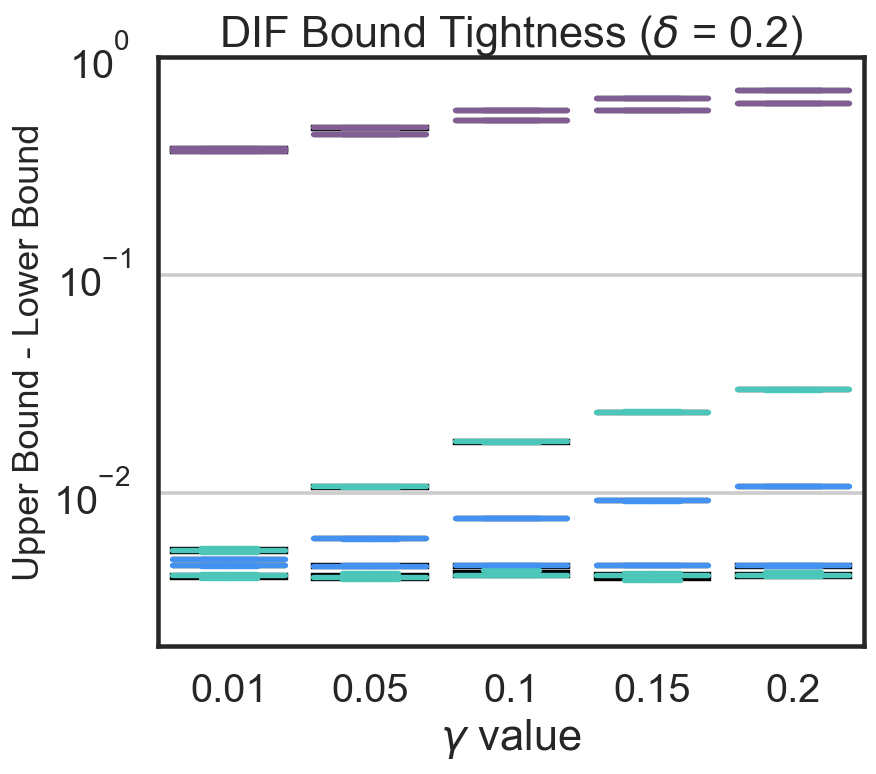

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('poster')
sns.set_style('white')
fig, ax = plt.subplots(figsize=(7,6), dpi=130)


adultPROPS = {
    'boxprops':{'facecolor':'#4392F1', 'edgecolor':'black'},
    'medianprops':{'color':'#4392F1'},
    'whiskerprops':{'color':'#4392F1'},
    'capprops':{'color':'#4392F1'}
}

germanPROPS = {
    'boxprops':{'facecolor':'#4BC6B9', 'edgecolor':'black'},
    'medianprops':{'color':'#4BC6B9'},
    'whiskerprops':{'color':'#4BC6B9'},
    'capprops':{'color':'#4BC6B9'}
}

creditPROPS = {
    'boxprops':{'facecolor':'#805D93', 'edgecolor':'black'},
    'medianprops':{'color':'#805D93'},
    'whiskerprops':{'color':'#805D93'},
    'capprops':{'color':'#805D93'}
}


ad = pd.DataFrame.from_dict(adult_upper)
cd = pd.DataFrame.from_dict(credit_upper)
gd = pd.DataFrame.from_dict(german_upper)
sns.boxplot(data=ad, **adultPROPS)
sns.boxplot(data=cd, **creditPROPS)
sns.boxplot(data=gd, **germanPROPS)

ad = pd.DataFrame.from_dict(adult_lower)
cd = pd.DataFrame.from_dict(credit_lower)
gd = pd.DataFrame.from_dict(german_lower)
sns.boxplot(data=ad, **adultPROPS)
sns.boxplot(data=cd, **creditPROPS)
sns.boxplot(data=gd, **germanPROPS)

#sns.stripplot(data=ad, color='#4392F1', edgecolor='white', linewidth=1)
#sns.stripplot(data=cd, color='#805D93', edgecolor='white', linewidth=1)
#sns.stripplot(data=gd, color='#4BC6B9', edgecolor='white', linewidth=1)
plt.semilogy()
plt.title(r'DIF Bound Tightness ($\delta$ = 0.2)')
plt.ylabel('Upper Bound - Lower Bound', fontsize=20)
ax = plt.gca()
ax.set_xticklabels([0.01, 0.05, 0.1, 0.15, 0.2])
ax.grid(axis='y')
plt.ylim((0.002, 1.0))
plt.xlabel(r'$\gamma$ value')


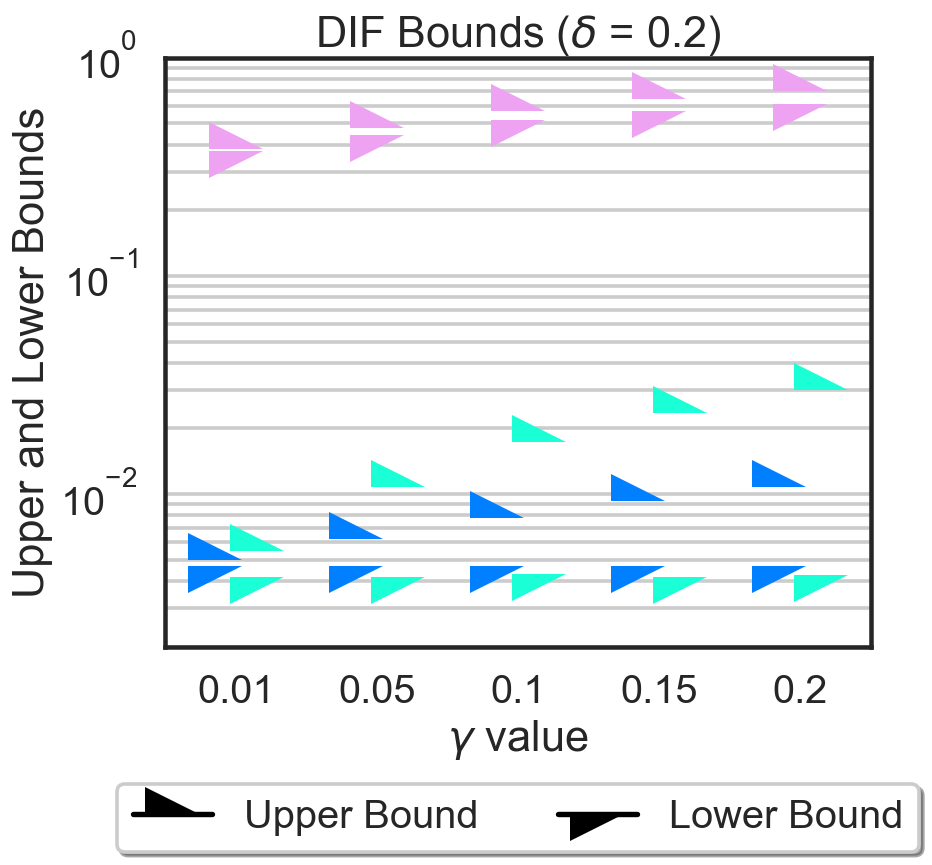

In [44]:
sns.set_context('poster')
sns.set_style('white')
fig, ax = plt.subplots(figsize=(7,6), dpi=130)

width = 0.075
dodge = 0.15
import matplotlib
lower_marker_style = dict(marker='>', fillstyle="top",  markersize=30, markeredgecolor = matplotlib.colors.colorConverter.to_rgba('white', alpha=.0))
upper_marker_style = dict(marker='>', fillstyle="bottom",  markersize=30, markeredgecolor = matplotlib.colors.colorConverter.to_rgba('white', alpha=.0))

#for i in range(5):
#    plt.fill_between(x=[i+1-width+dodge, i+1+width+dodge], y1=[np.mean(german_upper[i])], y2=[np.mean(german_lower[i])],
#                     color='#1AFFD5', alpha=0.75, edgecolor='#1AFFD5')
    #plt.axhline(y=np.mean(german_upper[i]), xmin=((i)/5)+0.06, xmax=((i+1)/5)-0.06, 
    #            color='#2a736b', linestyle='dotted')
    #plt.axhline(y=np.mean(german_lower[i]), xmin=((i)/5)+0.06, xmax=((i+1)/5)-0.06, 
    #            color='#2a736b', linestyle='dotted')  
plt.plot(np.asarray(range(1,6))+dodge, [np.mean(german_upper[i]) for i in range(5)], color='#1AFFD5', linewidth=0, **lower_marker_style)
plt.plot(np.asarray(range(1,6))+dodge, [np.mean(german_lower[i]) for i in range(5)], color='#1AFFD5', linewidth=0, **upper_marker_style)


#for i in range(5):
#    plt.fill_between(x=[i+1-width, i+1+width], y1=[np.mean(credit_upper[i])], y2=[np.mean(credit_lower[i])], 
#                     color='#EDA2F2', alpha=0.75, edgecolor='#EDA2F2')
    #plt.axhline(y=np.mean(credit_upper[i]), xmin=((i)/5)+0.06, xmax=((i+1)/5)-0.06, 
    #            color='#523b5e', linestyle='dotted')
    #plt.axhline(y=np.mean(credit_lower[i]), xmin=((i)/5)+0.06, xmax=((i+1)/5)-0.06, 
    #            color='#523b5e', linestyle='dotted') 
plt.plot(np.asarray(range(1,6)), [np.mean(credit_upper[i]) for i in range(5)], color='#EDA2F2', linewidth=0, **lower_marker_style)
plt.plot(np.asarray(range(1,6)), [np.mean(credit_lower[i]) for i in range(5)], color='#EDA2F2', linewidth=0, **upper_marker_style)


#for i in range(5):
#    plt.fill_between(x=[i+1-width-dodge, i+1+width-dodge], y1=[np.mean(adult_upper[i])], y2=[np.mean(adult_lower[i])], 
#                     color='#007FFF', alpha=0.75, edgecolor='#007FFF')
    #plt.axhline(y=np.mean(adult_upper[i]), xmin=((i)/5)+0.06, xmax=((i+1)/5)-0.06, 
    #            color='#2d5f9c', linestyle='dotted')
    #plt.axhline(y=np.mean(adult_lower[i]), xmin=((i)/5)+0.06, xmax=((i+1)/5)-0.06, 
    #            color='#2d5f9c', linestyle='dotted') 
    
    

plt.plot(np.asarray(range(1,6))-dodge, [np.mean(adult_upper[i]) for i in range(5)], linewidth=0, color='#007FFF', **lower_marker_style)
plt.plot(np.asarray(range(1,6))-dodge, [np.mean(adult_lower[i]) for i in range(5)], linewidth=0, color='#007FFF', **upper_marker_style)

plt.xlim((0.5, 5.5))
#plt.ylim((0.001, 0.1))
plt.semilogy()
plt.title(r'DIF Bounds ($\delta$ = 0.2)')
plt.ylabel('Upper and Lower Bounds')
ax = plt.gca()
ax.set_xticks([1,2,3,4,5])
ax.set_xticklabels([0.01, 0.05, 0.1, 0.15, 0.2])
ax.grid(axis='y')
plt.ylim((0.002, 1.0))
plt.xlabel(r'$\gamma$ value')
plt.grid(True, which="both", ls="-", axis='y')

plt.plot([-10000], [-10000], color='k', label="Upper Bound", **lower_marker_style)
plt.plot([-10000], [-10000], color='k', label="Lower Bound", **upper_marker_style)
#plt.scatter(x=np.asarray(range(1,6))-dodge, y = [np.mean(adult_lower[i]) for i in range(5)], marker=11, color='#4392F1')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=5)
plt.show()

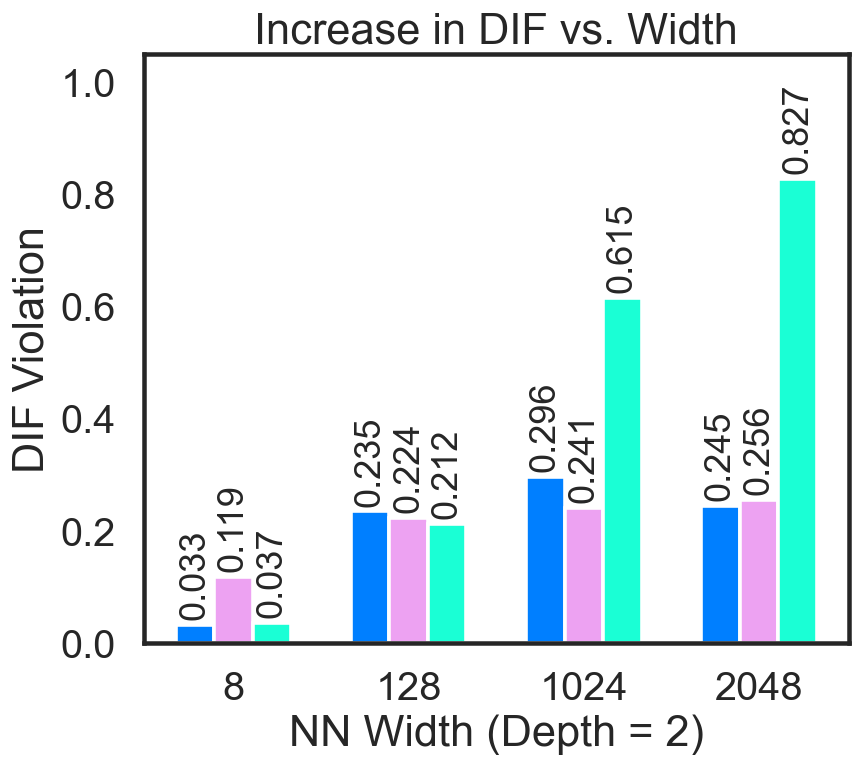

In [66]:
two_layer_widths = [8, 128, 1024, 2048]
credit_dro_upper = [0.119, 0.224, 0.241, 0.2560]
adult_dro_upper = [0.0325, 0.23517, 0.29682, 0.245]
german_dro_upper = [0.03777, 0.2126, 0.6155, 0.8273]

import matplotlib.pyplot as plt
import numpy as np

#species = ("Adult", "Credit", "German")
#penguin_means = {
#    '8': (0.0325, 0.119, 0.03777),
#    '128': (0.23517, 0.224, 0.2126),
#    '1024': (0.2968, 0.241, 0.6155),
#    '2048': (0.245, 0.256, 0.827),
#}

species = ("8", "128", "1024", "2048")
penguin_means = {
    'Adult': (0.033, 0.235, 0.296, 0.245),
    'Credit': (0.119, 0.224, 0.241, 0.256),
    'German': (0.037, 0.212, 0.615, 0.827)
}

x = np.arange(len(species))  # the label locations
width = 0.22  # the width of the bars
multiplier = 0

#fig, ax = plt.subplots(layout='constrained')
sns.set_context('poster')
sns.set_style('white')
fig, ax = plt.subplots(figsize=(7,6), dpi=130)

colors = ['#1AFFD5', '#EDA2F2', '#007FFF']
colors = colors[::-1]
ind = 0
for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width,  label=attribute, color=colors[multiplier])
    ax.bar_label(rects, padding=3, rotation=90, fontsize=20)
    multiplier += 1
    ind += 1
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('DIF Violation')
ax.set_title('Increase in DIF vs. Width')
ax.set_xticks(x + width, species)
ax.set_xlabel('NN Width (Depth = 2)')
#ax.legend(loc='upper left')
ax.set_ylim(0, 1.05)

plt.show()